In [1]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping

2024-01-04 09:38:26.424091: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-04 09:38:26.456735: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-04 09:38:26.602733: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-04 09:38:26.602780: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-04 09:38:26.633470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

*Chargement du Jeu de données* 

In [2]:
dataset = pd.read_csv("./LSTM_16notes.csv")
df = dataset.copy()

df_train = df.sample(frac=0.7, random_state=0)
df_valid = df.drop(df_train.index)

X_train = np.array([ eval(k) for k in df_train['X']])
X_test = np.array([ eval(k) for k in df_valid['X']])
y_train = np.array([ eval(k) for k in df_train['Y']])
y_test = np.array([ eval(k) for k in df_valid['Y']])

nombreDeNotesPrecedentes = len(X_train[0]) # nombre de notes précédentes à prendre en compte
formatNote = len(X_train[0][0]) # valeur de la note, durée, durée avant prochaine note

*Compilation des modèles*

20 neurones

2024-01-04 09:40:18.781337: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-04 09:40:18.781832: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/20
34145/34145 [==============================] - 105s 3ms/step - loss: 33658.6484 - mae: 65.7849 - val_loss: 32230.0332 - val_mae: 66.0238
Epoch 2/20
34145/34145 [==============================] - 104s 3ms/step - loss: 32183.7910 - mae: 64.4533 - val_loss: 32653.8496 - val_mae: 62.1479
Epoch 3/20
34145/34145 [==============================] - 104s 3ms/step - loss: 31276.9668 - mae: 62.7769 - val_loss: 31933.2305 - val_mae: 61.7266
Epoch 4/20
34145/34145 [==============================] - 104s 3ms/step - loss: 31012.1875 - mae: 62.6557 - val_loss: 31463.0117 - val_mae: 60.8349
Epoch 5/20
34145/34145 [==============================] - 105s 3ms/step - loss: 31513.0605 - mae: 62.1023 - val_loss: 32346.4082 - val_mae: 62.7674
Epoch 6/20
34145/34145 [==============================] - 106s 3ms/step - loss: 30900.9316 - mae: 61.1184 - val_loss: 32132.9766 - val_mae: 64.7352
Epoch 7/20
34145/34145 [==============================] - 106s 3ms/step - loss: 30871.3770 - mae: 61.5285 - val_

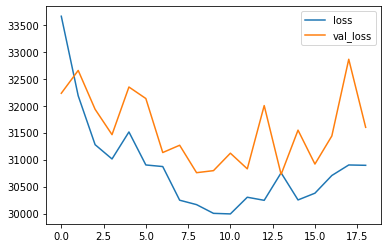

In [3]:
nombreDeNeurones = 20
batchNormalisation=False
dropout=False
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

Epoch 1/20
34145/34145 [==============================] - 102s 3ms/step - loss: 38274.5352 - mae: 70.2510 - val_loss: 33158.3242 - val_mae: 66.3647
Epoch 2/20
34145/34145 [==============================] - 102s 3ms/step - loss: 34777.2383 - mae: 65.8010 - val_loss: 35959.1328 - val_mae: 67.5815
Epoch 3/20
34145/34145 [==============================] - 101s 3ms/step - loss: 34075.4648 - mae: 65.5537 - val_loss: 1057365.0000 - val_mae: 109.2640
Epoch 4/20
34145/34145 [==============================] - 101s 3ms/step - loss: 34014.4062 - mae: 65.5466 - val_loss: 53239.9141 - val_mae: 98.6150
Epoch 5/20
34145/34145 [==============================] - 101s 3ms/step - loss: 34391.8281 - mae: 65.9250 - val_loss: 97985.5391 - val_mae: 62.0233
Epoch 6/20
34145/34145 [==============================] - 106s 3ms/step - loss: 34983.2305 - mae: 66.5588 - val_loss: 46061.3828 - val_mae: 66.0031
Erreur minimale atteinte : 33158.32421875


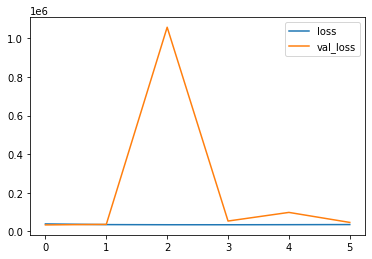

In [4]:
nombreDeNeurones = 20
batchNormalisation=True
dropout=False
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

Epoch 1/20
34145/34145 [==============================] - 111s 3ms/step - loss: 33696.9141 - mae: 66.8115 - val_loss: 32333.1836 - val_mae: 63.6392
Epoch 2/20
34145/34145 [==============================] - 109s 3ms/step - loss: 32748.0527 - mae: 63.9802 - val_loss: 31745.6035 - val_mae: 60.2159
Epoch 3/20
34145/34145 [==============================] - 109s 3ms/step - loss: 32519.5938 - mae: 63.3668 - val_loss: 32427.7520 - val_mae: 61.8729
Epoch 4/20
34145/34145 [==============================] - 107s 3ms/step - loss: 32645.1113 - mae: 63.4853 - val_loss: 32286.4355 - val_mae: 62.4474
Epoch 5/20
34145/34145 [==============================] - 107s 3ms/step - loss: 32905.9688 - mae: 64.1868 - val_loss: 31703.6660 - val_mae: 60.8122
Epoch 6/20
34145/34145 [==============================] - 103s 3ms/step - loss: 32442.6895 - mae: 63.5153 - val_loss: 32575.1797 - val_mae: 61.5907
Epoch 7/20
34145/34145 [==============================] - 107s 3ms/step - loss: 33348.7305 - mae: 65.9569 - val_

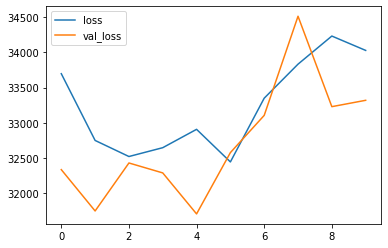

In [5]:
nombreDeNeurones = 20
batchNormalisation=False
dropout=True
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

Epoch 1/20
34145/34145 [==============================] - 106s 3ms/step - loss: 40252.1289 - mae: 73.3197 - val_loss: 40034.3594 - val_mae: 73.3625
Epoch 2/20
34145/34145 [==============================] - 104s 3ms/step - loss: 37684.2305 - mae: 71.3243 - val_loss: 35613.3320 - val_mae: 66.2182
Epoch 3/20
34145/34145 [==============================] - 104s 3ms/step - loss: 37145.5898 - mae: 71.0175 - val_loss: 47751.7266 - val_mae: 83.8897
Epoch 4/20
34145/34145 [==============================] - 104s 3ms/step - loss: 37583.0547 - mae: 71.3597 - val_loss: 36670.0039 - val_mae: 64.4568
Epoch 5/20
34145/34145 [==============================] - 104s 3ms/step - loss: 37463.0508 - mae: 71.5350 - val_loss: 38433.6797 - val_mae: 76.3160
Epoch 6/20
34145/34145 [==============================] - 104s 3ms/step - loss: 37950.3633 - mae: 72.2485 - val_loss: 38981.1875 - val_mae: 64.8914
Epoch 7/20
34145/34145 [==============================] - 104s 3ms/step - loss: 38536.4609 - mae: 72.8894 - val_

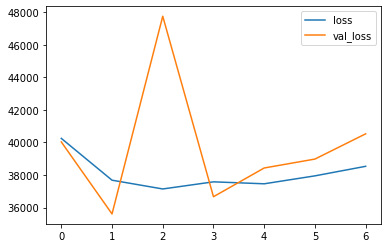

In [6]:
nombreDeNeurones = 20
batchNormalisation=True
dropout=True
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

100 neurones

Epoch 1/20
34145/34145 [==============================] - 185s 5ms/step - loss: 33608.5859 - mae: 67.6937 - val_loss: 33338.5664 - val_mae: 66.1647
Epoch 2/20
34145/34145 [==============================] - 183s 5ms/step - loss: 31422.2695 - mae: 63.1710 - val_loss: 30928.5801 - val_mae: 64.4702
Epoch 3/20
34145/34145 [==============================] - 183s 5ms/step - loss: 30727.9590 - mae: 61.7892 - val_loss: 31873.7129 - val_mae: 61.5742
Epoch 4/20
34145/34145 [==============================] - 182s 5ms/step - loss: 30054.3047 - mae: 61.1040 - val_loss: 30733.2480 - val_mae: 59.7368
Epoch 5/20
34145/34145 [==============================] - 184s 5ms/step - loss: 29856.4395 - mae: 60.9733 - val_loss: 30945.4434 - val_mae: 60.3048
Epoch 6/20
34145/34145 [==============================] - 182s 5ms/step - loss: 30170.9062 - mae: 61.2195 - val_loss: 30408.8477 - val_mae: 60.7392
Epoch 7/20
34145/34145 [==============================] - 183s 5ms/step - loss: 30139.4824 - mae: 61.2788 - val_

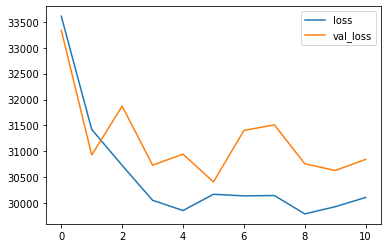

In [7]:
nombreDeNeurones = 100
batchNormalisation=False
dropout=False
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

Epoch 1/20
34145/34145 [==============================] - 191s 6ms/step - loss: 36887.1797 - mae: 67.6864 - val_loss: 123515.8359 - val_mae: 95.4426
Epoch 2/20
34145/34145 [==============================] - 187s 5ms/step - loss: 34161.1367 - mae: 65.3106 - val_loss: 62434.7852 - val_mae: 64.7217
Epoch 3/20
34145/34145 [==============================] - 187s 5ms/step - loss: 34012.3867 - mae: 65.3520 - val_loss: 39795.2227 - val_mae: 62.6204
Epoch 4/20
34145/34145 [==============================] - 188s 5ms/step - loss: 33477.9453 - mae: 65.0059 - val_loss: 101249.5078 - val_mae: 62.9573
Epoch 5/20
34145/34145 [==============================] - 187s 5ms/step - loss: 33582.9727 - mae: 65.4311 - val_loss: 457582.7188 - val_mae: 71.9594
Epoch 6/20
34145/34145 [==============================] - 186s 5ms/step - loss: 33034.2031 - mae: 64.9530 - val_loss: 47197.9336 - val_mae: 118.4974
Epoch 7/20
34145/34145 [==============================] - 187s 5ms/step - loss: 32969.1406 - mae: 65.0392 - 

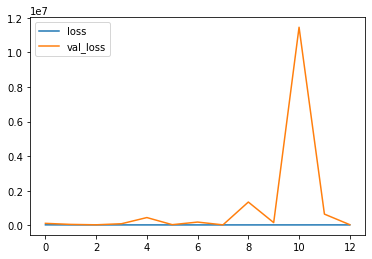

In [8]:
nombreDeNeurones = 100
batchNormalisation=True
dropout=False
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

Epoch 1/20
34145/34145 [==============================] - 186s 5ms/step - loss: 34288.4102 - mae: 68.4712 - val_loss: 32060.1016 - val_mae: 62.8866
Epoch 2/20
34145/34145 [==============================] - 194s 6ms/step - loss: 32533.5195 - mae: 64.5544 - val_loss: 31885.5781 - val_mae: 59.9694
Epoch 3/20
34145/34145 [==============================] - 194s 6ms/step - loss: 32439.0723 - mae: 64.2798 - val_loss: 31952.9336 - val_mae: 62.9331
Epoch 4/20
34145/34145 [==============================] - 197s 6ms/step - loss: 33326.4414 - mae: 64.5877 - val_loss: 32561.6582 - val_mae: 62.5586
Epoch 5/20
34145/34145 [==============================] - 197s 6ms/step - loss: 32770.3711 - mae: 63.9861 - val_loss: 32352.4746 - val_mae: 61.1990
Epoch 6/20
34145/34145 [==============================] - 197s 6ms/step - loss: 32736.8770 - mae: 64.2360 - val_loss: 32856.7031 - val_mae: 63.6708
Epoch 7/20
34145/34145 [==============================] - 198s 6ms/step - loss: 33112.0508 - mae: 65.1046 - val_

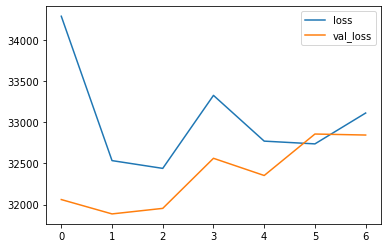

In [9]:
nombreDeNeurones = 100
batchNormalisation=False
dropout=True
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))

Epoch 1/20
34145/34145 [==============================] - 196s 6ms/step - loss: 39428.1719 - mae: 72.0050 - val_loss: 45209.1758 - val_mae: 65.4109
Epoch 2/20
34145/34145 [==============================] - 191s 6ms/step - loss: 37473.1406 - mae: 70.1623 - val_loss: 5180709.5000 - val_mae: 96.1551
Epoch 3/20
34145/34145 [==============================] - 190s 6ms/step - loss: 37039.9844 - mae: 69.9258 - val_loss: 4999199.0000 - val_mae: 98.1317
Epoch 4/20
34145/34145 [==============================] - 190s 6ms/step - loss: 37583.2891 - mae: 70.4049 - val_loss: 110794040.0000 - val_mae: 95.9585
Epoch 5/20
34145/34145 [==============================] - 190s 6ms/step - loss: 37072.4766 - mae: 69.8449 - val_loss: 355753.4375 - val_mae: 65.9752
Epoch 6/20
34145/34145 [==============================] - 191s 6ms/step - loss: 38174.3125 - mae: 70.8730 - val_loss: 1804455.8750 - val_mae: 72.6244
Erreur minimale atteinte : 45209.17578125


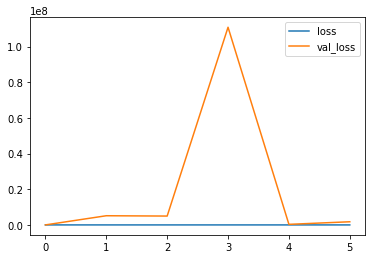

In [10]:
nombreDeNeurones = 100
batchNormalisation=True
dropout=True
# ------------------------------
nombreDeBatch = 32          # nombre de subdivisions du jeu de données
nombreDeEpoch = 20          # nombre de fois que l'on va parcourir le jeu de données
nombreDeEpochPatient = 5    # nombre d'epoch sans amélioration avant d'arrêter l'apprentissage

model = Sequential()
model.add( InputLayer(input_shape=(nombreDeNotesPrecedentes, formatNote)) )
model.add( LSTM(nombreDeNeurones, activation='relu') )
if dropout:
    model.add( Dropout(0.2) ) 
if batchNormalisation:
    model.add( BatchNormalization() )
model.add( Dense(formatNote) )
model.compile(optimizer='rmsprop', loss='mse',  metrics=['mae'])

early_stopping = EarlyStopping(
    min_delta=0.001, # quantité minimale considérable comme une amélioration
    patience=nombreDeEpochPatient,
    restore_best_weights=True,)
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    batch_size=nombreDeBatch,
    epochs=nombreDeEpoch,
    callbacks=[early_stopping],)
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
print("Erreur minimale atteinte : {}".format(history_df['val_loss'].min()))